# Calculate Citibike Station Demographics

## Get Citibike Station Data

To do this, we'll need a geolocated (data includes latitude and longitude) list of citibike stations. I created this dataset from the citibike API, and saved the result in a CSV file.

In [ ]:
import requests
import json
import csv

url = 'http://www.citibikenyc.com/stations/json'
r = requests.get(url)
stationjson = json.loads(r.content)

# Write stations list to CSV file
datatimestamp = stationjson['executionTime']
csvfilename = 'data/stationstatus'+datatimestamp+'.csv'
print("Writing to file {}".format(csvfilename))
fout = open(csvfilename, 'wb')
csvout = csv.writer(fout, quoting=csv.QUOTE_NONNUMERIC)
columns = set()
for jrow in stationjson['stationBeanList']:
    columns = columns | set(jrow.keys())
columns = list(columns)
csvout.writerow(columns)
for jrow in stationjson['stationBeanList']:
    crow = []
    for jcol in columns:
        if type(jrow[jcol]) == unicode:
            crow += [jrow[jcol].encode('utf-8')]
        else:
            crow += [jrow[jcol]]
    csvout.writerow(crow)
fout.close()

## Group Stations into Neighbourhoods

There are lots of Citibike stations.  Too many to get an easy handle on, or to easily match to neighbourhood demographics (e.g. how many people are in each station's neighbourhood, how old are they, what transport options did they tick on the US Census forms etc).  So first, we use the shapely library's point in polygon methods to work out which neighbourhood each station is in.

Point-in-polygon is a really important GIS tool, especially when you're offline and can't do OpenStreetMap or GoogleMaps gazetteer lookups to find out which points are in which area.

And… having done that, there’s a better way to do the point in polygon work… http://nbviewer.ipython.org/gist/kjordahl/7129098

In [2]:
import fiona
import csv
from shapely.geometry import Point
from shapely.geometry import asShape

mapfilename = 'data/nyc_neighbourhoods_wgs84.shp'
infilename = 'data/citibike_stations_list_raw.csv'
outfilename = 'data/citibike_stations_list_with_neighbourhoods.csv'

mapdata = fiona.open(mapfilename, 'r')
neighs = {}
for f in mapdata:
    props = f['properties']
    geom = asShape(f['geometry'])
    neighs[props['NTACode']] = geom

fout = open(outfilename, 'wb')
csvout = csv.writer(fout, quoting=csv.QUOTE_NONNUMERIC)
fin = open(infilename, 'rbU')
csvin = csv.reader(fin, delimiter=',')

headers = csvin.next()
latindex = headers.index('latitude')
lonindex = headers.index('longitude')
csvout.writerow(headers + ['Neighbourhood'])
for row in csvin:
    rowpt = Point(float(row[lonindex]), float(row[latindex]))
    rowneigh = ''
    for neigh, neighshape in neighs.iteritems():
        if neighshape.contains(rowpt):
            rowneigh = neigh
            continue
    csvout.writerow(row + [rowneigh])

fin.close()
fout.close()

Here are the stations and neighbourhoods together, courtesy of QGIS:
<img src="images/Stations and Neighbourhoods.png">

## Get Neighbourhood-level Demographic Data

Datasets:
* NYC neighbourhood outlines 
* NYC population for each neighbourhood https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Census-Tracts/37cg-gxjd
* Location and number of slots for each citibike station: citibike website
* Jersey City ward outlines
* Jersey City population by ward http://cityofjerseycity.com/uploadedFiles/For_Residents/Population%20by%20Ward.pdf  (sigh: pdf, and no date or metadata!) or http://data.jerseycitynj.gov. 

Except people take bikes from and to places.  One of those places is their home; another is their workplace.  Which needs another dataset: the at-work headcount  for each neighbourhood. This, we have to generate from other data.  And it’s going to get messy.  

A hunt for more data found some cool stuff in the US census, e.g. how people travel to work: http://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_14_5YR_S0801&prodType=table, and for data to fill in some gaps, like FIPS codes for New Jersey: http://lwd.dol.state.nj.us/labor/lpa/census/2kpub/geocodes.pdf

NTA map: http://www.nyc.gov/html/dcp/pdf/census/census2010/ntas.pdf

In [1]:
import pandas as pd

# Load in raw datasets
dfpopjersey = pd.read_csv('data/Jersey_City_Ward_Populations.csv', sep=',')
nycpopfile = 'data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv'
dfpopnyc = pd.read_csv(nycpopfile, sep=',')

# Create one headcount file for all areas
dfpop = pd.concat([
    dfpopnyc[dfpopnyc['Year'] == 2010],
    dfpopjersey.rename(columns={
        'Ward Code': 'NTA Code',
        'Ward Name': 'NTA Name'})
    ])

## Count the stations and docks in each neighbourhood

Mixing 3 datasets, to get resident headcount per bike for each neighbourhood:
* station-to-neighbourhood
* docks per station
* headcount per neighbourhood (NYC 2010 numbers only; Jersey City is separate)

Enter Pandas!
* Get the two headcount files: stick them together vertically to give an all-neighbourhoods headcount. 
* Left join the docks per station with the station-to-neigh data, then group by neighbourhood, to give the number of docks per neighbourhood.
* Left join the docks per neighbourhood with the neighbourhood headcounts, then calculate the headcount per dock for each neighbourhood. Then go play with the dataset!
* Play with the dataset = which neighs have most docks per head, how do the boroughs rank.
* Extensions: US census data includes transport to work, ethnic and age data.  Are there interesting things in there too?

Most of what you need for the Pandas part is in here: http://pandas.pydata.org/pandas-docs/stable/groupby.html

In [2]:
dfstation = pd.read_csv('data/citibike_stations_list_master.csv', sep=',')
dfdocks = pd.read_csv('data/stationstatus2015-12-11 11:54:45 AM.csv', sep=',')

dfdockneighs = pd.merge(
    dfdocks[['id', 'stationName', 'totalDocks']],
    dfstation[['id', 'Neighbourhood', 'Borough']],
    how='left', on=['id'])
neighgroups = dfdockneighs.groupby('Neighbourhood')
docksperneigh = neighgroups['totalDocks'].agg({
    'numStations': 'count',
    'numDocks': 'sum'})
docksperneigh['NTA Code'] = docksperneigh.index

# Compare dock numbers to headcounts
neighdata = pd.merge(
    docksperneigh[['NTA Code', 'numDocks', 'numStations']],
    dfpop[['NTA Code', 'Population']],
    how='left', on=['NTA Code'])
neighdata['dockdensity'] = neighdata['Population'] / neighdata['numDocks']

## Plot the dataset

So now we have numbers.  Let’s have a look at them in a visualization. 

Choropleths are useful, but not the easiest thing to create in Python.  Fortunately, the Bokeh library has that covered: http://bokeh.pydata.org/en/latest/docs/gallery/texas.html

Also see http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Vm9OIzbCk7s

This one, I like… https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/ - geopandas = ugly but fast (and will get prettier over time).  GeoPandas is going to be a really useful library for quickly plotting Pandas GIS data. 

The first time I did this, I couldn't remember how to actually see a plot. that's what the plt.show() is about - it's something that's missed off most tutorials on geopandas. 

The other thing is that, once the choropleth is plotted, it's hard to tell what the colours mean.  Fixing this meant adding a patch to the geopandas code: here's the patch http://stackoverflow.com/questions/31755886/choropleth-map-from-geopandas-geodatafame - the file I edited was plotting.py in the python2.7/site-packages/geopandas directory.  I didn't get that bit to work though.

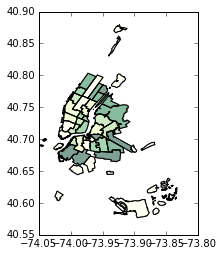

In [6]:
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

# Plot headcounts
gdf = geopandas.read_file('./data/nyc_neighbourhoods_wgs84.shp')
gdf.sort_values('NTACode', inplace=True)
neighdata.sort_values('NTA Code', inplace=True)
plotdata = pd.merge(
    gdf,
    neighdata.rename(columns={'NTA Code': 'NTACode'}),
    on=['NTACode'])
kw = dict(column='dockdensity', k=6, colormap='YlGn')
ax = plotdata.plot(scheme='QUANTILES', **kw)
plt.show()

Hmm. What the heck is that area in the bottom right of the map?  AFAIK, there aren't any citibike stations there, unless someone's been stocking up the beach.  Looking more carefully at the station data shows 4 stations marked as BK99, including Sands St & Navy St.  Looking at the station map (https://member.citibikenyc.com/map/) shows Sands St & Navy St up near the Navy Yard. Am not sure how this happened, but it needs checking.  This kind of sanity checking is why we plot and map data. 

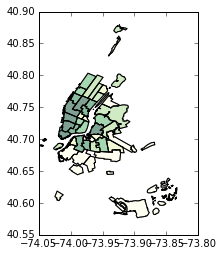

In [7]:
kw = dict(column='numDocks', k=6, colormap='YlGn')
ax = plotdata.plot(scheme='QUANTILES', **kw)
plt.show()